In [1]:
# Library Import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Custom helper import
from helper.cadplot import conf_matrix
from helper.utils import log_results, plot_training_history,evaluate_model


In [2]:
# Trial run for mini dataset due to processing times.
trail_run = True

In [3]:
# Path Define
# File prefix name
_prefix = ''
_datapath="/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/"
# Set the path to your datasets
if trail_run:
    path = _datapath + "trial_dataset/binary/"
    _prefix = "trail_"
else:
    path = _datapath + "dataset/binary/"
    _prefix = "final_"

TRAIN_DATA_DIR = path + 'train'
VALIDATION_DATA_DIR = path + 'val'
TEST_DATA_DIR = path + 'testX'

In [4]:
# Set a random seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)


In [5]:
# Helper function

# Save model 
def model_save(model,file_path):
    model.save(file_path)

In [6]:
# Create a DataFrame for the test data
test_df = pd.DataFrame({'filename': os.listdir(TEST_DATA_DIR), 'class': None})
test_df['class'] = 0  # You can set a default class label for all test images (e.g., 0)


In [7]:
# Model Param setup
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Batch size
batch_size = 32
# Iteration
EPOCHS = 20

In [8]:
# Use ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)
# Use ImageDataGenerator for testing without data augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255)
# Create a data generator for training (with validation split)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary',
    subset='training'  # specify that this is the training set
)

# Create a data generator for validation (with validation split)
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary',
    subset='validation'  # specify that this is the validation set
)

test_generator = test_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 82 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [9]:
prefix = _prefix + 'DenseNet121'

# Load the pre-trained DenseNet121 model
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers of DenseNet121
for layer in densenet121_model.layers:
    layer.trainable = False

# Create a new model with DenseNet121 and additional layers for binary classification
densenet121_custom_model = Sequential()
densenet121_custom_model.add(densenet121_model)
densenet121_custom_model.add(Flatten())
densenet121_custom_model.add(Dense(128, activation='relu'))
densenet121_custom_model.add(Dense(1, activation='sigmoid'))

# Model summary
densenet121_custom_model.summary()

# Compile the DenseNet121 custom model
densenet121_custom_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the DenseNet121 custom model
start_time = time.time()

history_densenet121_custom = densenet121_custom_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

end_time = time.time()
# Save the VGG16 custom model (modify the saving path)
model_save(densenet121_custom_model, f'model/{prefix}_model.h5')

2023-12-12 22:16:35.347909: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-12 22:16:35.347937: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-12 22:16:35.347945: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-12 22:16:35.348008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 22:16:35.348244: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


29084464/29084464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13460289 (51.35 MB)
Trainable params: 6422785 (24.50 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


Epoch 1/20


2023-12-12 22:16:42.151682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-12 22:16:42.339207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 9s 3s/step - loss: 44.5202 - accuracy: 0.4756 - val_loss: 36.1563 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 2s 613ms/step - loss: 17.5072 - accuracy: 0.5610 - val_loss: 7.2530 - val_accuracy: 0.7000
Epoch 3/20
3/3 [==============================] - 2s 794ms/step - loss: 10.2985 - accuracy: 0.5366 - val_loss: 21.1607 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 2s 638ms/step - loss: 20.6821 - accuracy: 0.5000 - val_loss: 21.1864 - val_accuracy: 0.5000
Epoch 5/20
3/3 [==============================] - 2s 777ms/step - loss: 13.8072 - accuracy: 0.5854 - val_loss: 3.7924 - val_accuracy: 0.7500
Epoch 6/20
3/3 [==============================] - 2s 791ms/step - loss: 5.0157 - accuracy: 0.7805 - val_loss: 5.4403 - val_accuracy: 0.8000
Epoch 7/20
3/3 [==============================] - 2s 639ms/step - loss: 6.9172 - accuracy: 0.7683 - val_loss: 7.5795 - val_accuracy: 0.6500
Epoch 8/20
3/3 [==========

/Users/taiaburrahman/Desktop/Udg/CADx/Challenge/tf/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 5s 754ms/step
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


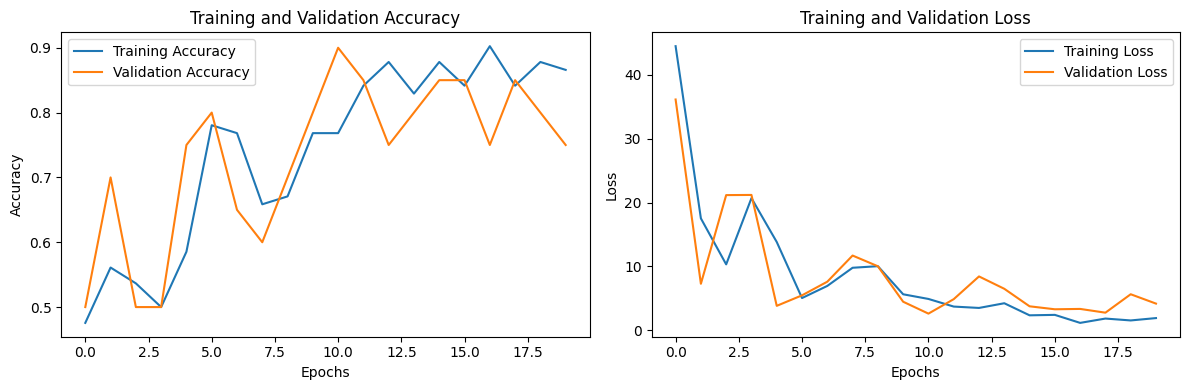

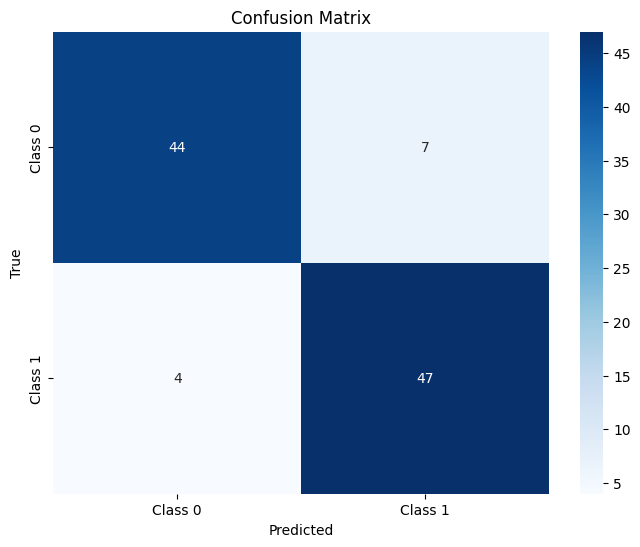

In [10]:
custom_model = densenet121_custom_model
model_history = history_densenet121_custom
# Assuming you have variables vgg16_custom_model and test_generator
test_loss, test_accuracy, conf_mat, classification_rep = evaluate_model(custom_model, test_generator)
# Assuming you have variables like start_time, end_time, test_accuracy, conf_mat, and classification_rep
log_results(prefix, start_time, end_time, test_accuracy, conf_mat, classification_rep)
print(model_history.history.keys())
# Assuming you have a variable model and prefix
plot_training_history(model_history, prefix)
# Create a heatmap for the confusion matrix
conf_matrix(conf_mat)